In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [3]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

In [4]:
root_dir = '/media/akumar/Data/nse'

In [5]:
import pickle

In [6]:
with open('alpha_datalist_expanded.dat', 'rb') as f:
    alpha_datalist = pickle.load(f)

In [7]:
alpha_datalist = pd.DataFrame(alpha_datalist)

### Simoid Fitting

In [8]:
# Fit sigmoids to:

# (1) each algorithm, each selection method, each sparsity
# (2) the same, but separate by betawidth
# (3) combine the different SNR together

In [9]:
list(alpha_datalist.keys())

['df_name',
 'betawidth',
 'sparsity',
 'alpha',
 'sa',
 'kappa',
 'selection_method',
 'np_ratio',
 'cov_indices']

In [10]:
from sigmoid import Sigmoid

In [27]:
# Treat the 3 different cases

sigmoid_df = []

# High noise, normal n/p ratio
case1 = apply_df_filters(alpha_datalist, kappa=1, np_ratio=4)
sigmoid_df.extend(calc_sigmoids(case1, 1))

# Normal noise, low data
case2 = apply_df_filters(alpha_datalist, kappa=5, np_ratio=2)
sigmoid_df.extend(calc_sigmoids(case2, 2))

# ideal
case3 = apply_df_filters(alpha_datalist, kappa=10, np_ratio=16)
sigmoid_df.extend(calc_sigmoids(case3, 3))

In [12]:
algorithms = np.unique(alpha_datalist['df_name'].values)
selection_methods = np.unique(alpha_datalist['selection_method'].values)
sparsity = np.unique(alpha_datalist['sparsity'].values)
betawidth = np.unique(alpha_datalist['betawidth'].values)

In [13]:
from sigmoid import Sigmoid

In [15]:
def calc_sigmoids(case_df, caseno):

    sigmoid_df = []    
    # Separate by betawidth
    for k, s in enumerate(sparsity):
        for i, algorithm in enumerate(algorithms):
            for j, selection_method in enumerate(selection_methods):
                for l, bw in enumerate(betawidth):
                    adl = apply_df_filters(case_df, df_name=algorithm,
                               sparsity=s, selection_method=selection_method,
                                betawidth=bw)            
                    if adl.shape[0] == 0:
                        pdb.set_trace()
                    # Take sa vs. log alpha and fit a sigmoid to it
                    sigmoid = Sigmoid()
                    alpha_mask = np.ma.log(adl['alpha'].values[0])
                    mask = np.invert(alpha_mask.mask)
                    alpha_ = np.log(adl['alpha'].values[0][mask])
                    sa_ = adl['sa'].values[0][mask]
                    try:
                        sigmoid.fit(alpha_, sa_)
                        sigmoid_df.append({'df':algorithm, 'sparsity':s, 'selection_method': selection_method,
                           'kappa' : 5, 'np_ratio': 4, 'coefs': sigmoid.coef_, 'cov' : sigmoid.coef_cov,
                           'betawidth': bw, 'caseno': caseno})
                    except:
                        sigmoid_df.append({'df':algorithm, 'sparsity':s, 'selection_method': selection_method,
                                           'kappa' : 5, 'np_ratio': 4, 'coefs': np.nan, 'cov' : np.nan,
                                           'betawidth' : bw, 'caseno': caseno})                
    return sigmoid_df

### NAN inspection

In [74]:
# How many nans are there?
count = 0
for elem in sigmoid_df:
    if np.all(np.isnan(elem['coefs'])):
        count +=1

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


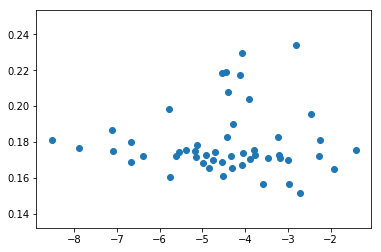

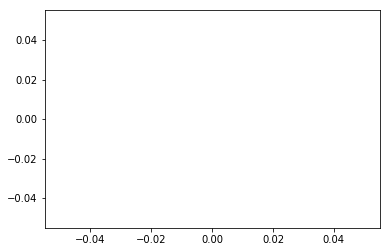

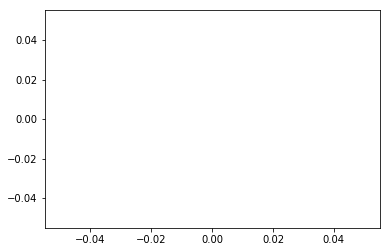

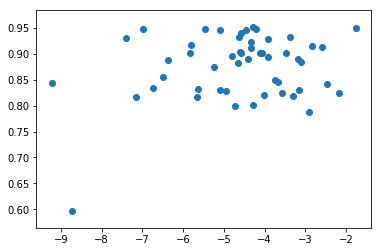

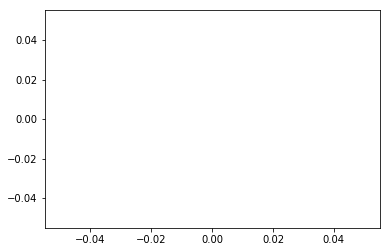

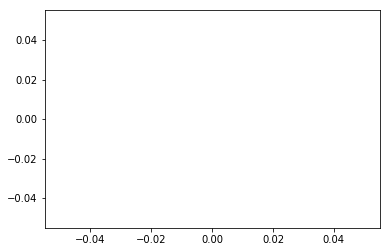

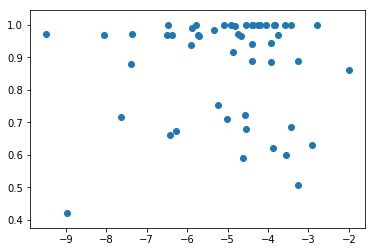

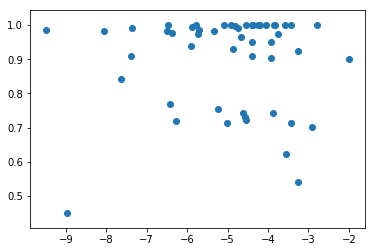

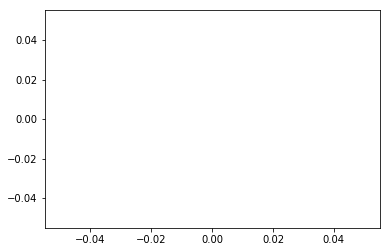

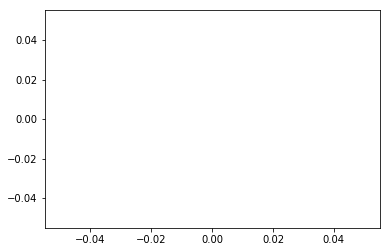

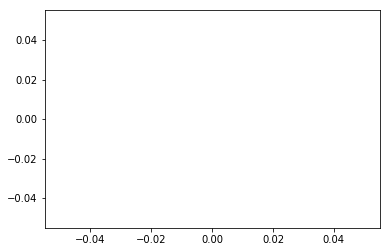

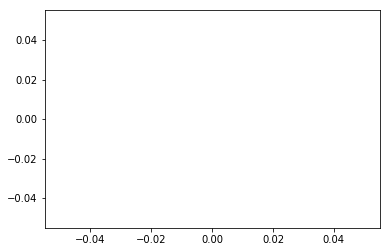

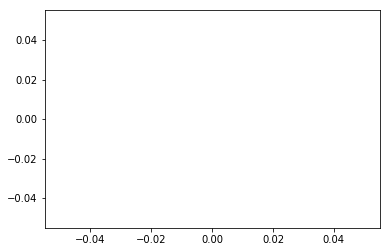

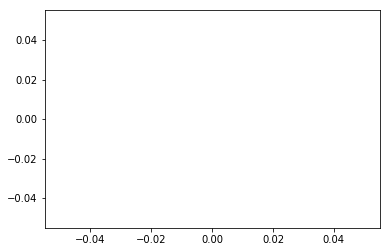

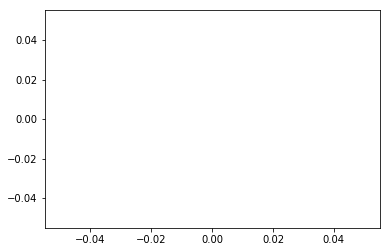

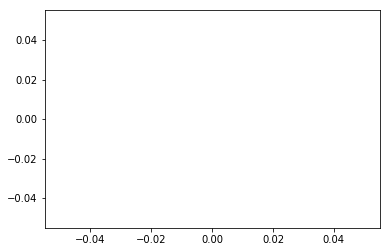

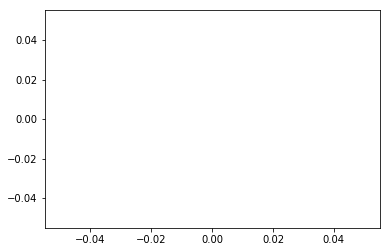

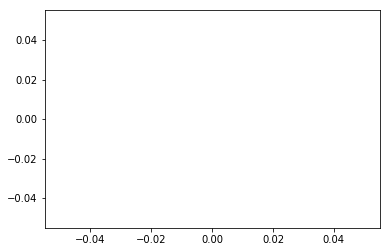

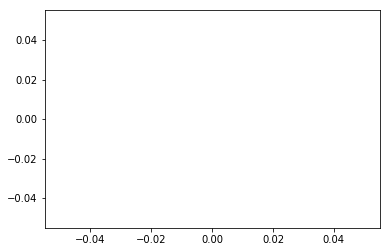

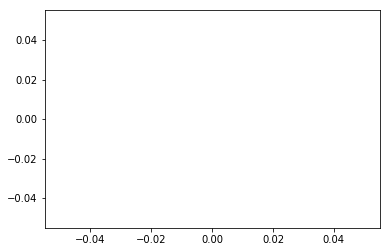

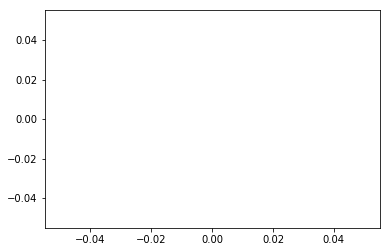

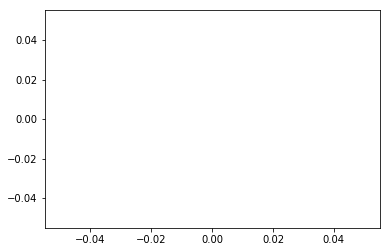

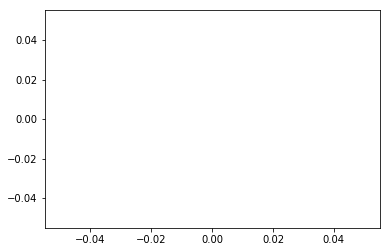

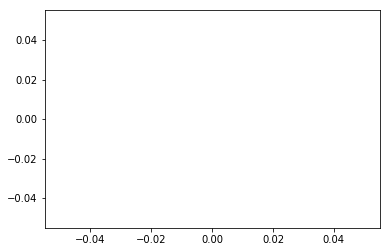

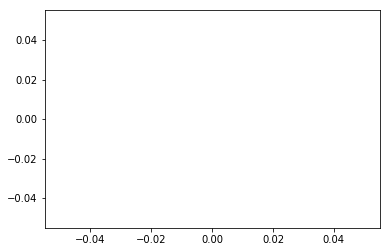

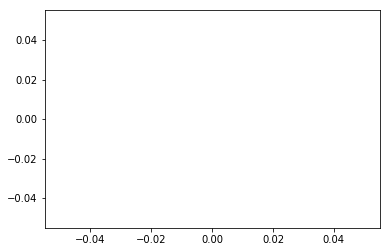

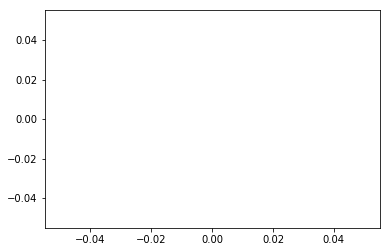

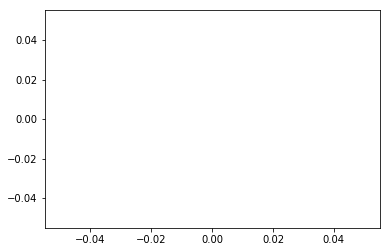

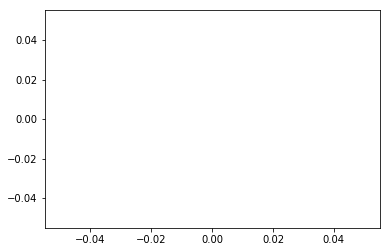

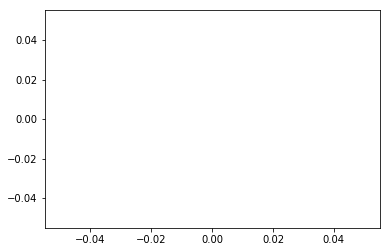

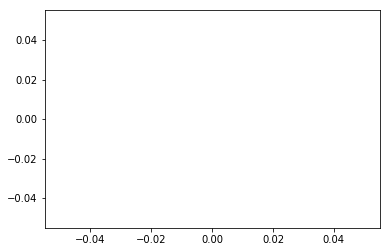

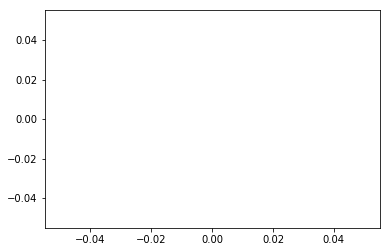

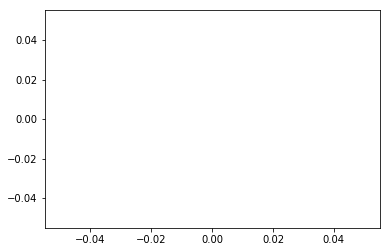

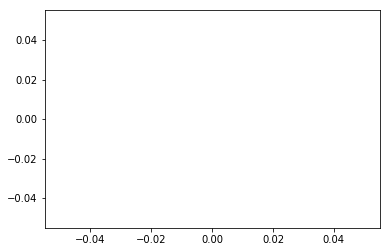

In [23]:
# What to do about nans?
for i, elem in enumerate(sigmoid_df):
    if np.all(np.isnan(elem['coefs'])):
        # grab the raw alpha/sa data:
        adl = apply_df_filters(alpha_datalist, df_name=elem['df'],
              sparsity=elem['sparsity'], selection_method=elem['selection_method'])            
        
        # Plot alpha and sa and save away
        alpha_mask = np.ma.log(adl['alpha'].values[0])
        mask = np.invert(alpha_mask.mask)
        alpha_ = np.log(adl['alpha'].values[0][mask])
        sa_ = adl['sa'].values[0][mask]
        fig, ax = plt.subplots()        
        ax.scatter(alpha_, sa_)
        fig.savefig('abberation%d.png' % i)

In [ ]:
# Other summary metrics: 

# 'Expected' FNR/FPR and variance around it
# Use the statistics from above and sigmoid fits to construct decision trees about
# what algorithm to use/selection method to use considering 
# alpha, (eta?), SNR, n/p, density

# Come up with concrete 'Best of best' statistics

# Contrast with theory, when do the theoretical results seem helpful?

# Investigate 
# (1) aberrations in point clouds 
# (2) wtf is going on with eta calculation

### Plotting

In [28]:
sigmoid_df = pd.DataFrame(sigmoid_df)

In [33]:
from scipy import signal

In [34]:
# Low pass filter the signal y(x)
# f0: filter cutoff frequency
def lpfilter(y, f0):
    
    # 2nd order lowpass butterworth filter
    b, a = signal.butter(2, f0)
    
    z = signal.filtfilt(b, a, y)
    return z

In [20]:
# For each case, plot the 3 parameters of the sigmoid across sparsity. Create subpanels for each
# relevant selection method

In [29]:
list(sigmoid_df.keys())

['df',
 'sparsity',
 'selection_method',
 'kappa',
 'np_ratio',
 'coefs',
 'cov',
 'betawidth',
 'caseno']

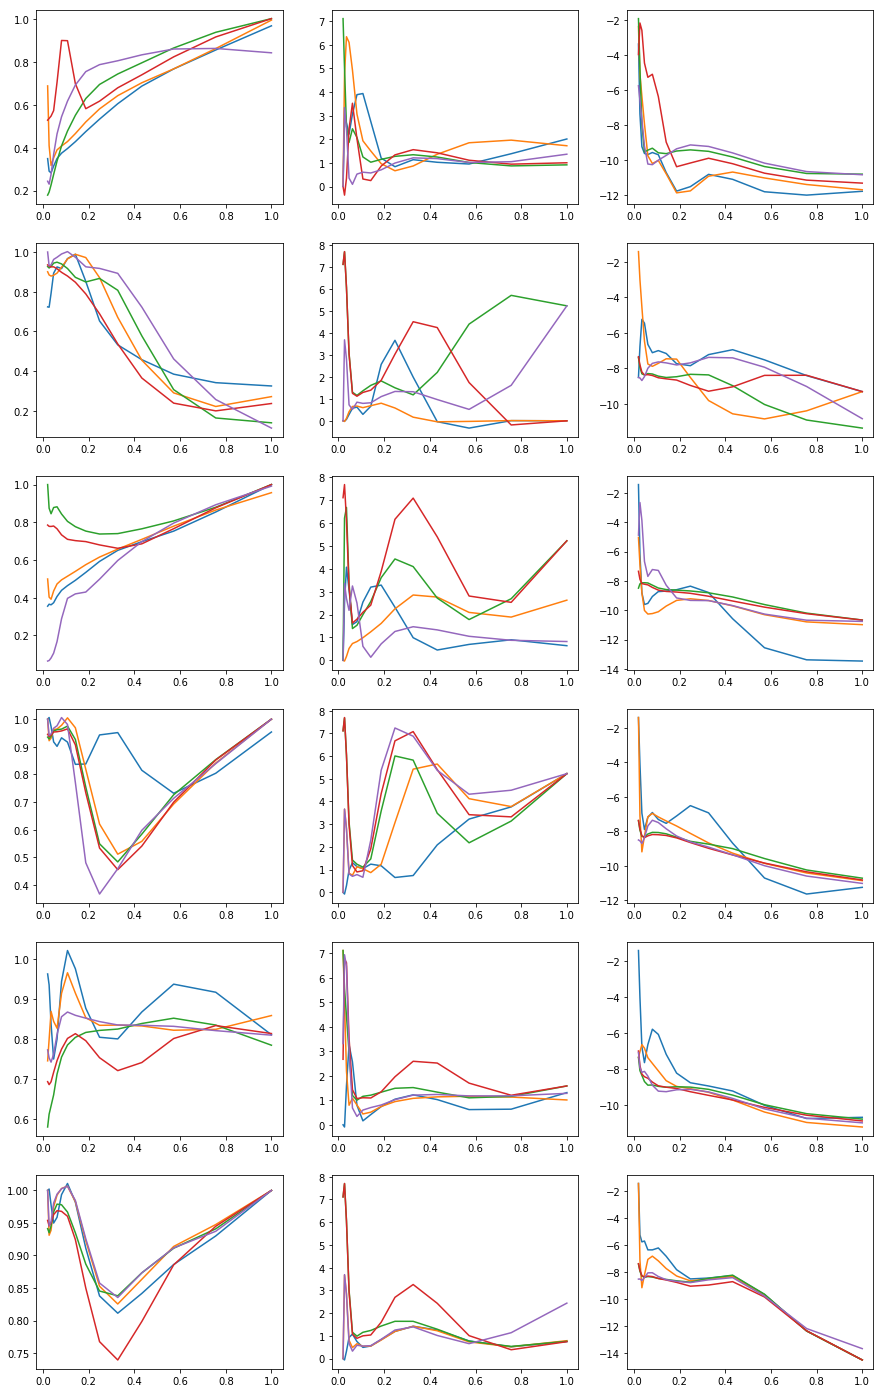

In [42]:
# Case 1
case_df = apply_df_filters(sigmoid_df, caseno=1)

fig, ax = plt.subplots(6, 3, figsize = (15, 25))

selection_methods = ['AIC', 'BIC', 'CV', 'empirical_bayes', 'gMDL', 'oracle']
for i, sm in enumerate(selection_methods):
    
    # Iterating over the sigmoid parameters:
    for j in range(3):
        
        a = ax[i, j]
        
        for k, alg in enumerate(algorithms):

            x = []
            y = []
            yerr = []
            
            # Plot across sparsity
            for l, s in enumerate(sparsity):
                
                sdf_ = apply_df_filters(case_df, sparsity=s, selection_method=sm, df=alg)
                if not np.any(np.isnan(sdf_.iloc[0]['coefs'])):
                    x.append(s)
                    if j == 0:
                        y.append(min(1, sdf_.iloc[0]['coefs'][0] + sdf_.iloc[0]['coefs'][-1]))
                        yerr.append(np.sqrt(sdf_.iloc[0]['cov'][0, 0] + sdf_.iloc[0]['cov'][-1, -1]))
                    else:
                        y.append(sdf_.iloc[0]['coefs'][j])
                        yerr.append(np.sqrt(sdf_.iloc[0]['cov'][j, j]))
                        
            # Smooth
            y_smooth = lpfilter(y, 0.5)
                        
            a.plot(x, y_smooth)

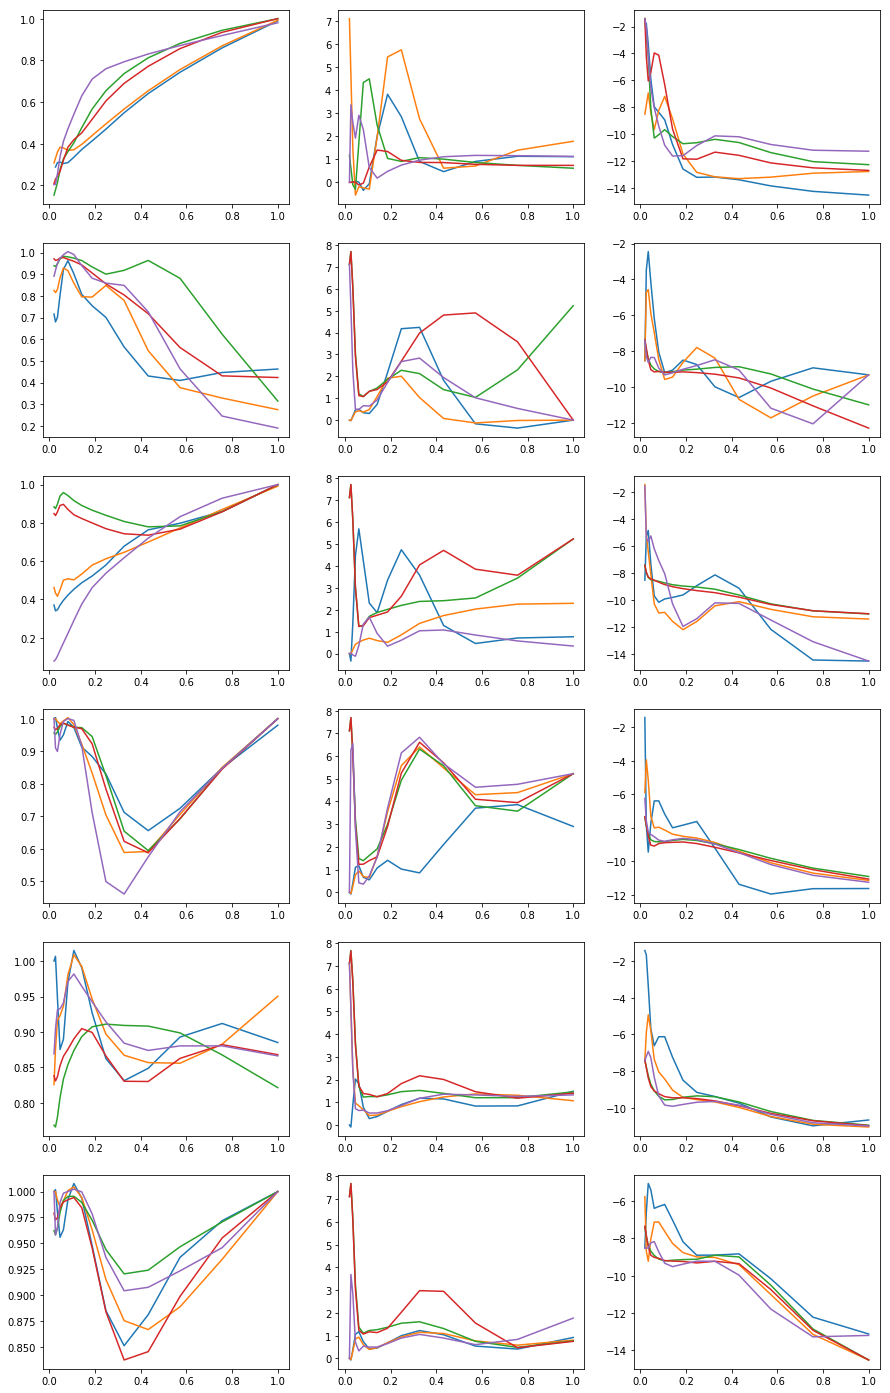

In [37]:
# Case 2
case_df = apply_df_filters(sigmoid_df, caseno=2)

fig, ax = plt.subplots(6, 3, figsize = (15, 25))

selection_methods = ['AIC', 'BIC', 'CV', 'empirical_bayes', 'gMDL', 'oracle']
for i, sm in enumerate(selection_methods):
    
    # Iterating over the sigmoid parameters:
    for j in range(3):
        
        a = ax[i, j]
        
        for k, alg in enumerate(algorithms):

            x = []
            y = []
            yerr = []
            
            # Plot across sparsity
            for l, s in enumerate(sparsity):
                
                sdf_ = apply_df_filters(case_df, sparsity=s, selection_method=sm, df=alg)
                if not np.any(np.isnan(sdf_.iloc[0]['coefs'])):
                    x.append(s)
                    if j == 0:
                        y.append(min(1, sdf_.iloc[0]['coefs'][0] + sdf_.iloc[0]['coefs'][-1]))
                        yerr.append(np.sqrt(sdf_.iloc[0]['cov'][0, 0] + sdf_.iloc[0]['cov'][-1, -1]))
                    else:
                        y.append(sdf_.iloc[0]['coefs'][j])
                        yerr.append(np.sqrt(sdf_.iloc[0]['cov'][j, j]))
                        
            # Smooth
            y_smooth = lpfilter(y, 0.5)
                        
            a.plot(x, y_smooth)

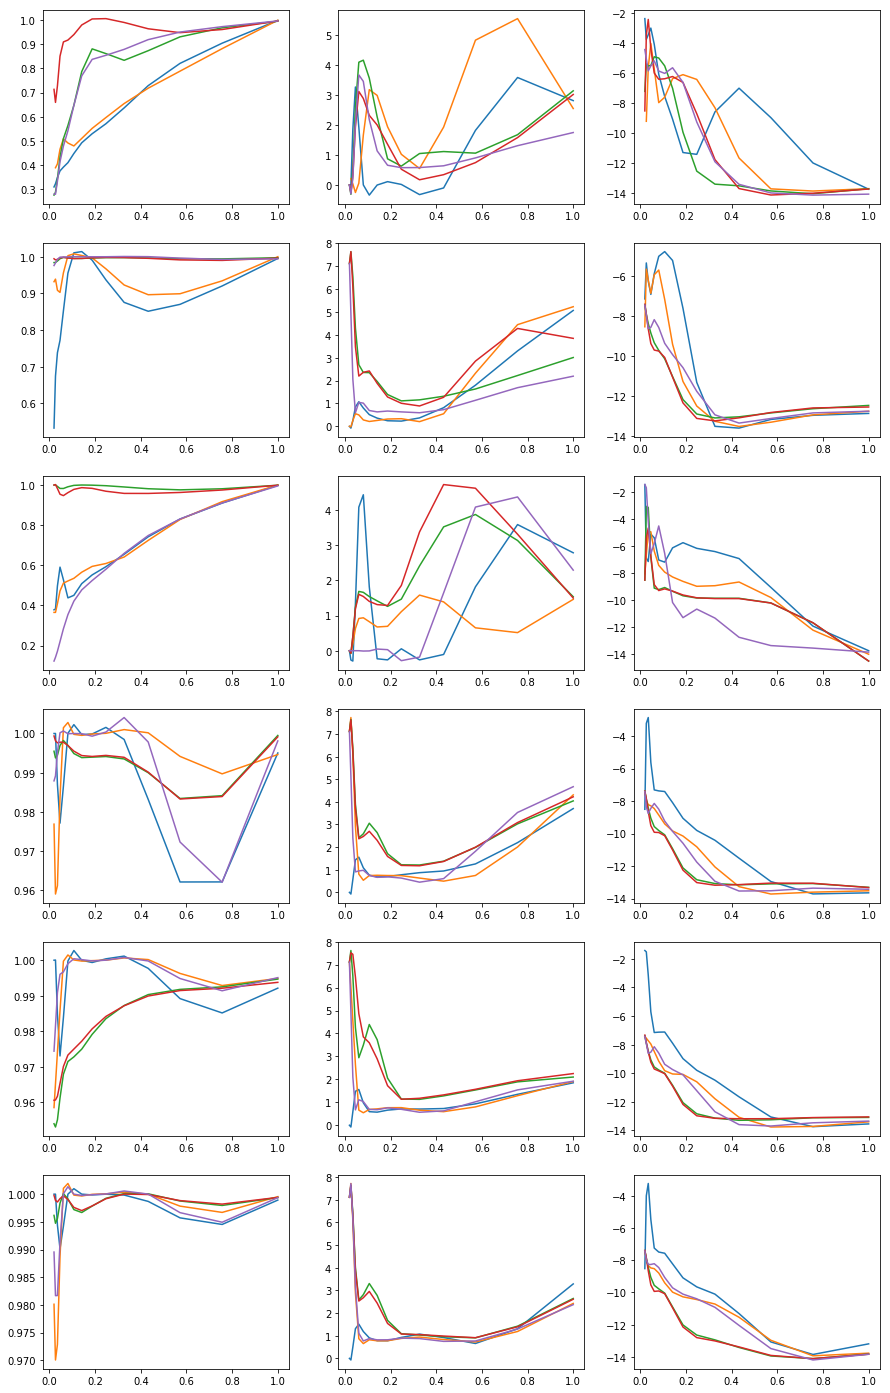

In [39]:
# Case 3
case_df = apply_df_filters(sigmoid_df, caseno=3)

fig, ax = plt.subplots(6, 3, figsize = (15, 25))

selection_methods = ['AIC', 'BIC', 'CV', 'empirical_bayes', 'gMDL', 'oracle']
for i, sm in enumerate(selection_methods):
    
    # Iterating over the sigmoid parameters:
    for j in range(3):
        
        a = ax[i, j]
        
        for k, alg in enumerate(algorithms):

            x = []
            y = []
            yerr = []
            
            # Plot across sparsity
            for l, s in enumerate(sparsity):
                
                sdf_ = apply_df_filters(case_df, sparsity=s, selection_method=sm, df=alg)
                if not np.any(np.isnan(sdf_.iloc[0]['coefs'])):
                    x.append(s)
                    if j == 0:
                        y.append(min(1, sdf_.iloc[0]['coefs'][0] + sdf_.iloc[0]['coefs'][-1]))
                        yerr.append(np.sqrt(sdf_.iloc[0]['cov'][0, 0] + sdf_.iloc[0]['cov'][-1, -1]))
                    else:
                        y.append(sdf_.iloc[0]['coefs'][j])
                        yerr.append(np.sqrt(sdf_.iloc[0]['cov'][j, j]))
                        
            # Smooth
            y_smooth = lpfilter(y, 0.5)
                        
            a.plot(x, y_smooth)

In [43]:
# Lump into 3 sparsity groups and plot using grouped boxplots
import seaborn as sns

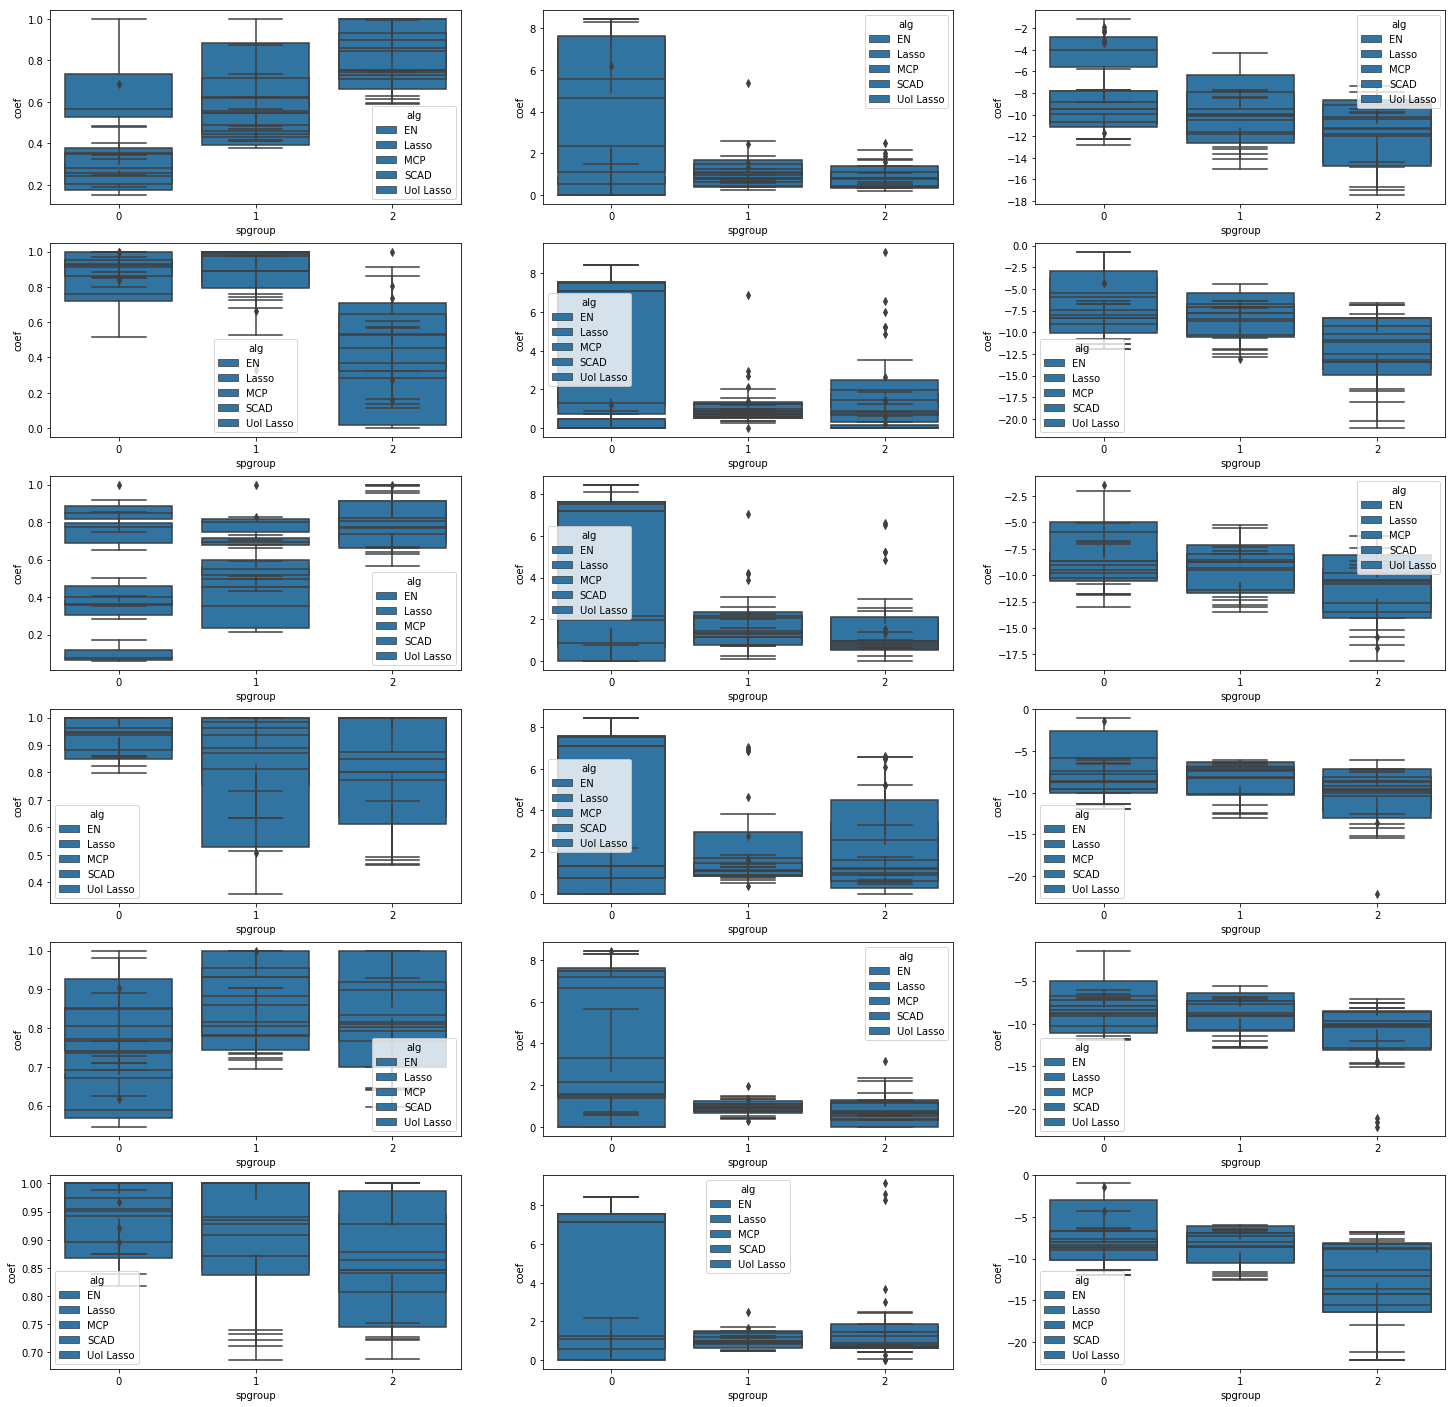

In [46]:
# Case 1
case_df = apply_df_filters(sigmoid_df, caseno=1)

fig, ax = plt.subplots(6, 3, figsize = (25, 25))

selection_methods = ['AIC', 'BIC', 'CV', 'empirical_bayes', 'gMDL', 'oracle']
for i, sm in enumerate(selection_methods):
    
    # Iterating over the sigmoid parameters:
    for j in range(3):
        
        a = ax[i, j]
        
        for k, alg in enumerate(algorithms):

            x = []
            y = []
            yerr = []
            
            # Divide sparsity
            sparsity_groups = np.array_split(sparsity, 3)
            
            # dataframe for plotting
            plt_df = []
            
            for l, spg in enumerate(sparsity_groups):                
                sdf_ = apply_df_filters(case_df, selection_method=sm, df=alg)
                sdf_ = sdf_.loc[sdf_['sparsity'].isin(spg)]

                # Collect the coefficients
                for row in range(sdf_.shape[0]):
                    if not np.any(np.isnan(sdf_.iloc[row]['coefs'])):
                        if j == 0:                     
                            coef = min(1, sdf_.iloc[row]['coefs'][0] + sdf_.iloc[row]['coefs'][-1])                    
                        else:
                            coef = sdf_.iloc[row]['coefs'][j]
                    
                    plt_df.append({'spgroup' : l, 'coef': coef, 'alg' : alg})
            plt_df = pd.DataFrame(plt_df)
            sns.boxplot(x = 'spgroup', y='coef', data=plt_df, hue='alg', ax = a)

In [ ]:
# Next stage of reduction --> choose particular algorithm + sm combinations

In [ ]:
# 